# Book Genre Prediction from Plot Summaries

This notebook was created to train and test different machine learning models using scki-learn library. The idea is to feed the deep learning model with book plot summaries and the models learns and predicts its genres.

The book plot summaries used for this project was taken from http://www.cs.cmu.edu/~dbamman/booksummaries.html
The environment used for training and testing was kaggle: https://www.kaggle.com/shwe87/



In [1]:
#pip install scikit-learn --upgrade

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import csv
import json
import matplotlib.pyplot as plt 
import seaborn as sns
from tqdm import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
import re
# Performance metric
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
import nltk

import warnings
warnings.simplefilter('ignore', UserWarning)

# Data cleaning and analysis
The first step is to understand the data and pre-process it and make it adequate for our neural network. The steps followed are:

1. Read from the text file which contains all the book summaries, genre, author, book title, etc. and visualize the data and save it to a dataframe.
2. Delete all the rows where the values for genre and summary are empty because these rows won't be any use for us.
3. The values in column Genres are in json format, convert them to list format. Each book has been given more than one genre.
4. To reduce complexity in the model, multilabel is discarded and will take in account only one label. To do so, a study was done to see which genres are the more frequent ones and only  these will be taken in account.

In [3]:
book_summary_df = pd.read_csv("../input/book-genre-prediction-data-preparation/book_summaries.csv")

# Data Analysis
In the following plot, Fiction is the genre with most plots. For this project, the first 10 genres with largest counts have been taken.

As the neural network doesn't understand strings and will be feeding on numbers. Each of these genres have been encoded with a number & saved in a dictionary.

1. Science Fiction
2. Crime Fiction
3. Fantasy
4. Children's Literature
5. Mystery
6. Young adult literature
7. Suspense
8. Non-fiction

In [4]:
valid_genres = [#'Speculative fiction',
                'Science Fiction','Crime Fiction','Non-fiction','Children\'s literature',
                'Fantasy', 'Mystery', 'Suspense', 'Young adult literature']

# Cleaning

As one book can have more than one valid labels, the duplicates are eliminated. For example, if a book "Example" had ["Fiction", "Crime Fiction", "Novel", "Fantasy"] then the cell above created four lines for each of these genres for the book "Example". In order to have only one genre per book (and not to confuse the neural network), the duplicates have been deleted and only the first occurrance has been saved.


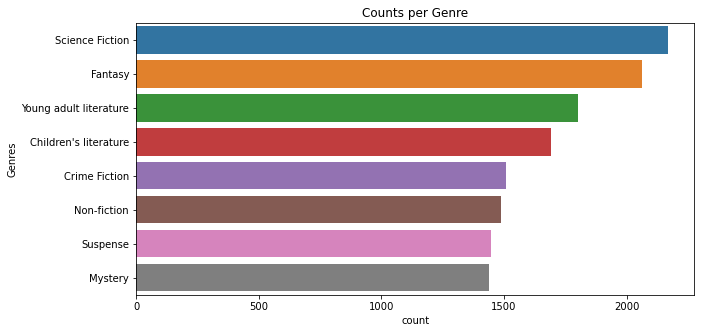

In [5]:
plt.figure(figsize=(10,5))
sns.countplot(data=book_summary_df, order=book_summary_df.Genres.value_counts().index, y='Genres')
plt.title("Counts per Genre")
plt.show()

In [6]:
book_summary_df['String Counts'] = book_summary_df.Genres.str.len()

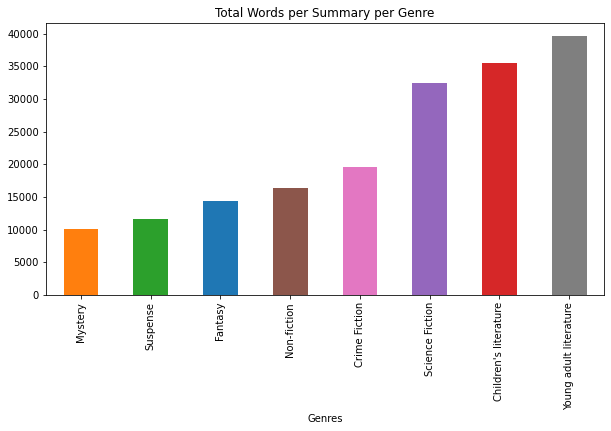

In [7]:
plt.figure(figsize=(10,5))
df = book_summary_df.groupby(['Genres'])['String Counts'].sum().reset_index()
df.sort_values(['String Counts'], ascending=True).head(10).plot(kind='bar', y='String Counts', x='Genres',
                legend=False, color=['tab:orange', 'tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:purple','tab:red', 'tab:gray', 'tab:olive'], ax=plt.gca())
plt.title("Total Words per Summary per Genre")
plt.show()

# Text Cleaning

- Get rid of periods and puntuation as these won't be of any use to the neural network.
- Turn all string to lowercase.


In [8]:
import string
def clean(summary):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    text = summary.translate(table)
    text = re.sub(r"[^a-zA-Z0-9\s]"," ", summary.lower())
    return text

In [9]:
book_summary_df['Summary'] = book_summary_df['Summary'].map(lambda summary : clean(summary))
book_summary_df.head(5)

,Unnamed: 0,Book Title,Book Author,Summary,Genres,String Counts
0,0,Animal Farm,George Orwell,old major the old boar on the manor farm ca...,Children's literature,21
1,1,A Clockwork Orange,Anthony Burgess,alex a teenager living in near future englan...,Science Fiction,15
2,4,A Fire Upon the Deep,Vernor Vinge,the novel posits that space around the milky ...,Fantasy,7
3,6,A Wizard of Earthsea,Ursula K. Le Guin,ged is a young boy on gont one of the larger...,Fantasy,7
4,8,Blade Runner 3: Replicant Night,K. W. Jeter,living on mars deckard is acting as a consul...,Science Fiction,15


# Training, Validation and Test

Split the data into training and testing sets.

    Training data --> 80% of the total
    Testing data --> 20% of the total



Training dataset = 10886
Testing dataset = 2722


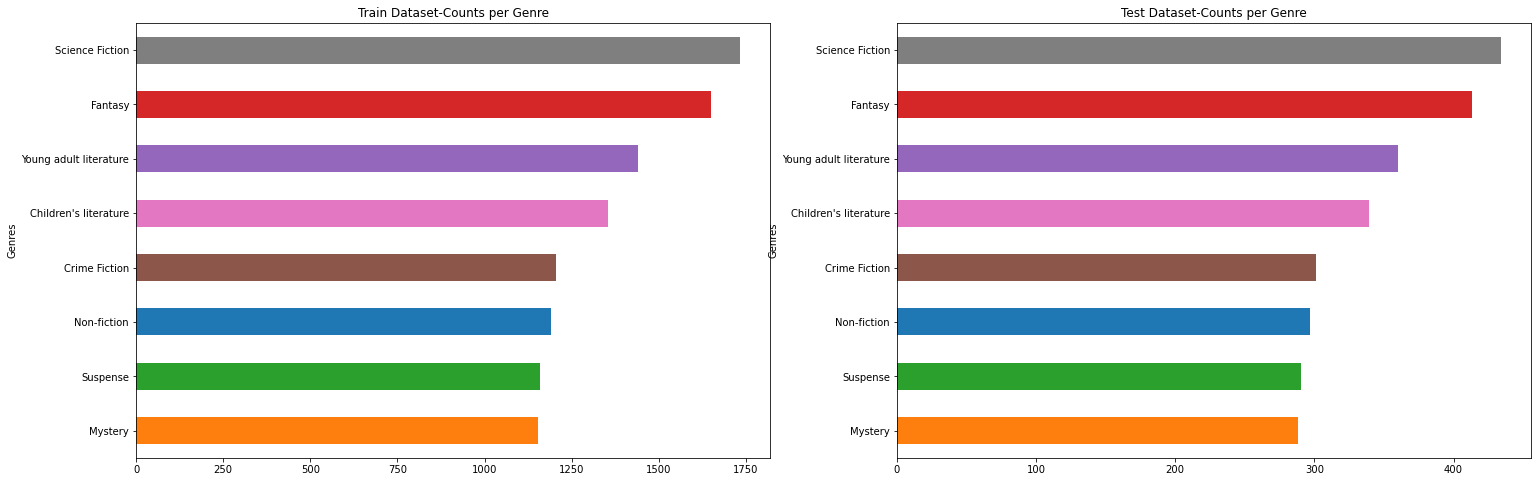

In [10]:
#Split to train and test data
train, test = train_test_split(book_summary_df, random_state=42, test_size=0.2, shuffle=True, stratify=book_summary_df['Genres'])

train_x = train.Summary
train_y = train.Genres
test_x = test.Summary.to_numpy()
test_y = test.Genres.to_numpy()
test_titles = test['Book Title'].to_numpy()

print("Training dataset = {}".format(len(train_x)))
print("Testing dataset = {}".format(len(test_x)))

colors=['tab:orange', 'tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:purple','tab:red', 'tab:gray', 'tab:olive']
plt.figure(figsize=(25,8))
plt.subplot(1,2,1).set_title("Train Dataset-Counts per Genre")
train.groupby('Genres').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.subplot(1,2,2).set_title("Test Dataset-Counts per Genre")
test.groupby('Genres').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.show()

# Feature Extraction
For all the models, TFIDF vectors have been used and he classifier used is the OneVsRestClassifier from the sklearn library.

In [11]:
import joblib
from time import time
# [training duration, testing duration, Test Accuracy

benchmarks = {'NB' : [0.0, 0.0, 0.0],
              'NB_tuned':  [0.0, 0.0, 0.0],
              'SVC' :  [0.0, 0.0, 0.0],
              'SVC_tuned':  [0.0, 0.0, 0.0],
              'LR' :  [0.0, 0.0, 0.0],
              'LR_tuned':  [0.0, 0.0, 0.0],
                }

In [12]:
tfidf = TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), use_idf=True)

# Model 1: Naive Bayes

## Results

* ngram=(1,5) -- Test Accuracy of 0.429 --
* ngram=(1,2) -- Test Accuracy of 0.491 -- 0.284
* ngram=(1,3) -- Test Accuracy of 0.459 -- 
* ngram=(1,1) -- Test Accuracy of 0.575 -- 0.372

In [13]:
# Define a pipeline combining a text feature extractor with multi class classifier
t0 = time()
NB_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1), use_idf=True)),
                ('clf', OneVsRestClassifier(MultinomialNB())),
            ])
NB_pipeline.fit(train_x, train_y)
benchmarks['NB'][0] = (time() - t0)/60
filename = "./NB_model.sav"
joblib.dump(NB_pipeline, filename)
print("Training took {:.3f} [seconds] to complete and has been saved as {}".format(benchmarks['NB'][0],filename))
print("####Before tuning:####")
print('Train Accuracy : %.3f'%NB_pipeline.score(train_x, train_y))
print('Test Accuracy : %.3f'%NB_pipeline.score(test_x, test_y))

Training took 0.070 [seconds] to complete and has been saved as ./NB_model.sav
####Before tuning:####
Train Accuracy : 0.824
Test Accuracy : 0.555


## Tune the model
Tune the model to get the best accuracy.

In [14]:
NB_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__estimator__alpha', 'clf__estimator__class_prior', 'clf__estimator__fit_prior', 'clf__estimator', 'clf__n_jobs'])

In [15]:
from sklearn.model_selection import GridSearchCV

In [16]:
t0 = time()
parameters = {    
    'tfidf__use_idf': (True, False),
    #'tfidf__lowercase': (True, False), 
    'tfidf__norm': ('l1', 'l2'),  
    'clf__estimator__alpha': (1, 0.1, 0.01, 0.001, 0.0001)  
     }
NB_grid = GridSearchCV(NB_pipeline, param_grid=parameters, n_jobs=-1, verbose=5)
NB_grid.fit(train_x, train_y)
#print("Training took: {:.2f} ".format(time() - t0))
benchmarks['NB_tuned'][0] = (time() - t0)/60

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [17]:
filename = "./NB_tuned_model.sav"
joblib.dump(NB_grid, filename)
print('Best Parameters : ',NB_grid.best_params_)
print("Training took: {:.3f}[minutes] to complete and has been saved as {}".format(benchmarks['NB_tuned'][0]/60,filename))

Best Parameters :  {'clf__estimator__alpha': 0.01, 'tfidf__norm': 'l2', 'tfidf__use_idf': False}
Training took: 0.047[minutes] to complete and has been saved as ./NB_tuned_model.sav


In [18]:
print("####After tuning:####")
print('Train Accuracy : %.3f'%NB_grid.best_estimator_.score(train_x, train_y))
print('Test Accuracy : %.3f'%NB_grid.best_estimator_.score(test_x, test_y))

####After tuning:####
Train Accuracy : 0.975
Test Accuracy : 0.626


# Model 2: Support Vector Classification
## Results
* ngram=(1,1) -- TA = 0.628
* ngram=(1,2) -- TA = 0.635
* ngram=(1,3) -- TA = 0.632
* ngram=(1,4) -- TA = 0.628 -- 83[seconds]

In [19]:
t0 = time()
SVC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,2))),
                ('clf', OneVsRestClassifier(LinearSVC(), n_jobs=1)),
            ])
SVC_pipeline.fit(train_x, train_y)
benchmarks['SVC'][0] = (time() - t0)/60
#print("Training complete! Saving trained model....")
filename = "./SVC_model.sav"
joblib.dump(SVC_pipeline, filename)
print("Training took: {:.3f}[seconds] to complete and has been saved as {}".format(benchmarks['SVC'][0],filename))

Training took: 0.394[seconds] to complete and has been saved as ./SVC_model.sav


In [20]:
print("####Before tuning:####")
print('Train Accuracy : %.3f'%SVC_pipeline.score(train_x, train_y))
print('Test Accuracy : %.3f'%SVC_pipeline.score(test_x, test_y))

####Before tuning:####
Train Accuracy : 0.999
Test Accuracy : 0.640


## Tuning for SVC

SVC model doesn't need any tuning because the train and test accuracy score are already quite near to the desired output.

With ngram=(1,2)

Best Parameters :  {'clf__estimator__fit_intercept': True, 'tfidf__ngram_range': (1, 2), 'tfidf__use_idf': True}
Training took: 8.658[minutes] to complete and has been saved as ./SVC_tuned_model.sav
####After tuning:####
Train Accuracy : 0.999
Test Accuracy : 0.635

In [21]:
SVC_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__estimator__C', 'clf__estimator__class_weight', 'clf__estimator__dual', 'clf__estimator__fit_intercept', 'clf__estimator__intercept_scaling', 'clf__estimator__loss', 'clf__estimator__max_iter', 'clf__estimator__multi_class', 'clf__estimator__penalty', 'clf__estimator__random_state', 'clf__estimator__tol', 'clf__estimator__verbose', 'clf__estimator', 'clf__n_jobs'])

In [22]:
t0 = time()
parameters = {
              'tfidf__use_idf': (True, False),
              'tfidf__max_df': [0.3, 0.5, 0.8, 1.0],
              'clf__estimator__loss' : ['hinge', 'squared_hinge'],
              #'tfidf__ngram_range': [(1,1), (1,2),(1,3)],
              'clf__estimator__penalty' : ["l1", "l2"],
              'clf__estimator__fit_intercept': [True, False],
              'clf__estimator__C': [0.01, 1.0, 2.0]
              #'clf__estimator__solver': ('newton-cg', 'sag','saga','lbfgs')
             }
SVC_grid = GridSearchCV(SVC_pipeline,param_grid=parameters, n_jobs=-1, verbose=5)
SVC_grid.fit(train_x, train_y)
#print("Training took: {:.2f} ".format(time() - t0))
benchmarks['SVC_tuned'][0] = (time() - t0)/60

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [23]:
filename = "./SVC_tuned_model.sav"
joblib.dump(SVC_grid, filename)
print('Best Parameters : ',SVC_grid.best_params_)
print("Training took: {:.3f}[minutes] to complete and has been saved as {}".format(benchmarks['SVC_tuned'][0]/60,filename))
print("####After tuning:####")
print('Train Accuracy : %.3f'%SVC_grid.best_estimator_.score(train_x, train_y))
print('Test Accuracy : %.3f'%SVC_grid.best_estimator_.score(test_x, test_y))

Best Parameters :  {'clf__estimator__C': 2.0, 'clf__estimator__fit_intercept': True, 'clf__estimator__loss': 'hinge', 'clf__estimator__penalty': 'l2', 'tfidf__max_df': 0.3, 'tfidf__use_idf': True}
Training took: 1.505[minutes] to complete and has been saved as ./SVC_tuned_model.sav
####After tuning:####
Train Accuracy : 0.999
Test Accuracy : 0.641


Output of the above cell:

Best Parameters :
* {'clf__estimator__C': 2.0, 
* 'clf__estimator__fit_intercept': True,
* 'clf__estimator__loss': 'squared_hinge',
* 'clf__estimator__penalty': 'l2',
* 'tfidf__max_df': 0.5,
* 'tfidf__use_idf': True}


Training took: 94.708[minutes] to complete and has been saved as ./SVC_tuned_model.sav

####After tuning:####
* Train Accuracy : 0.999
* Test Accuracy : 0.641


# Model 3: Logistic Regression

## Results
* ngram=(1,1) -- TA=0.625 8[s]
* ngram=(1,2) -- TA=0.612    39[s]
* ngram=(1,3) -- TA= 0.593 73[seconds]

In [24]:
t0 = time()
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='liblinear'), n_jobs=1)),
            ])
LogReg_pipeline.fit(train_x, train_y)
benchmarks['LR'][0] = (time() - t0)/60
#print("Training complete! Saving trained model....")
filename = "./LogReg_model.sav"
joblib.dump(LogReg_pipeline, filename)
print("Training took: {:.3f}[seconds] to complete and has been saved as {}".format(benchmarks['LR'][0],filename))
print("####Before tuning:####")
print('Train Accuracy : %.3f'%LogReg_pipeline.score(train_x, train_y))
print('Test Accuracy : %.3f'%LogReg_pipeline.score(test_x, test_y))

Training took: 0.129[seconds] to complete and has been saved as ./LogReg_model.sav
####Before tuning:####
Train Accuracy : 0.880
Test Accuracy : 0.625


## With solver as sag -- No changes
* ngram=(1,1) -- TA = 0.625 8[seconds]
* ngram = (1,2) -- TA = 0.612
* ngram = (1,3) -- TA = -- 0.593 70[seconds]!!

In [25]:
#TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))
t0 = time()
LogReg_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,1))),
                ('clf', OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)),
            ])
LogReg_pipeline.fit(train_x, train_y)
benchmarks['LR'][0] = (time() - t0)/60
#print("Training complete! Saving trained model....")
filename = "./LogReg_model.sav"
joblib.dump(LogReg_pipeline, filename)
print("Training took: {:.3f}[seconds] to complete and has been saved as {}".format(benchmarks['LR'][0],filename))
print("####Before tuning:####")
print('Train Accuracy : %.3f'%LogReg_pipeline.score(train_x, train_y))
print('Test Accuracy : %.3f'%LogReg_pipeline.score(test_x, test_y))

Training took: 0.134[seconds] to complete and has been saved as ./LogReg_model.sav
####Before tuning:####
Train Accuracy : 0.880
Test Accuracy : 0.625


In [26]:
LogReg_pipeline.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'tfidf', 'clf', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'clf__estimator__C', 'clf__estimator__class_weight', 'clf__estimator__dual', 'clf__estimator__fit_intercept', 'clf__estimator__intercept_scaling', 'clf__estimator__l1_ratio', 'clf__estimator__max_iter', 'clf__estimator__multi_class', 'clf__estimator__n_jobs', 'clf__estimator__penalty', 'clf__estimator__random_state', 'clf__estimator__solver', 'clf__estimator__tol', 'clf__estimator__verbose', 'clf__estimator__warm_start', 'clf__estimator', 'clf__n_jobs'])

In [27]:
t0 = time()
parameters = {'clf__estimator__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
              'tfidf__use_idf': (True, False),
              #'tfidf__max_df': [0.3, 0.5, 0.8, 1.0],
              'clf__estimator__fit_intercept': [True, False],
              'clf__estimator__C': [0.01, 1.0, 2.0],
              #'clf__estimator__max_iter': [25]
              'clf__estimator__solver': ('newton-cg', 'sag','saga','lbfgs')
             }
LogReg_grid = GridSearchCV(LogReg_pipeline,param_grid=parameters, n_jobs=-1, verbose=5)
LogReg_grid.fit(train_x, train_y)
#print("Training took: {:.2f} ".format(time() - t0))
benchmarks['LR_tuned'][0] = (time() - t0)/60

Fitting 5 folds for each of 192 candidates, totalling 960 fits


In [28]:
filename = "./LR_tuned_model.sav"
joblib.dump(LogReg_grid, filename)
print('Best Parameters : ',LogReg_grid.best_params_)
print("Training took: {:.3f}[minutes] to complete and has been saved as {}".format(benchmarks['LR_tuned'][0]/60,filename))

Best Parameters :  {'clf__estimator__C': 2.0, 'clf__estimator__fit_intercept': True, 'clf__estimator__penalty': 'l2', 'clf__estimator__solver': 'lbfgs', 'tfidf__use_idf': True}
Training took: 1.099[minutes] to complete and has been saved as ./LR_tuned_model.sav


In [29]:
print("####After tuning:####")
print('Train Accuracy : %.3f'%LogReg_grid.best_estimator_.score(train_x, train_y))
print('Test Accuracy : %.3f'%LogReg_grid.best_estimator_.score(test_x, test_y))

####After tuning:####
Train Accuracy : 0.940
Test Accuracy : 0.633


Training with Decision Tree:
Training took: 1102.355[seconds] to complete and has been saved as ./DTC_model.sav
####Before tuning:####
Train Accuracy : 0.999
Test Accuracy : 0.331

DTC_pipeline = Pipeline([
                ('tfidf', TfidfVectorizer(stop_words=stop_words, ngram_range=(1,3))),
                ('clf', OneVsRestClassifier(DecisionTreeClassifier(), n_jobs=-1)),
            ])

# Test Models
Test the trained models with validation data.

In [30]:
def save_benchmarks(estimator, estimator_name,x, y, benchmarks):
    t0 = time()
    pred = estimator.predict(test_x)
    benchmarks[estimator_name][1] = (time() - t0)/60
    benchmarks[estimator_name][2] = accuracy_score(y, pred)*100

In [31]:
#NB
save_benchmarks(estimator=NB_pipeline, estimator_name='NB', x=test_x, y=test_y, benchmarks=benchmarks)
save_benchmarks(estimator=NB_grid.best_estimator_, estimator_name='NB_tuned', x=test_x, y=test_y, benchmarks=benchmarks)
#LR
save_benchmarks(estimator=LogReg_pipeline, estimator_name='LR', x=test_x, y=test_y, benchmarks=benchmarks)
save_benchmarks(estimator=LogReg_grid.best_estimator_, estimator_name='LR_tuned', x=test_x, y=test_y, benchmarks=benchmarks)
#SVC
save_benchmarks(estimator=SVC_pipeline, estimator_name='SVC', x=test_x, y=test_y, benchmarks=benchmarks)
save_benchmarks(estimator=SVC_grid.best_estimator_, estimator_name='SVC_tuned', x=test_x, y=test_y, benchmarks=benchmarks)
print("Benchmaks created!")

Benchmaks created!


In [32]:
df = pd.DataFrame.from_dict(benchmarks, orient='index',columns=['Trained Duration[m]', 'Testing Duration[m]', 'Accuracy(%)'])
df.index.rename('Models', inplace=True)
df

,Trained Duration[m],Testing Duration[m],Accuracy(%)
Models,,,
NB,0.070424,0.016258,55.547392
NB_tuned,2.845161,0.016388,62.637766
SVC,0.394362,0.028475,64.033799
SVC_tuned,90.322383,0.038774,64.144012
LR,0.133835,0.016189,62.527553
LR_tuned,65.917469,0.015956,63.335783


In [33]:
def save_print_results(pred, labels, titles, save_file):
    print('##########################################\n#\tTest accuracy is {:.4f}%\t#\n##########################################'.format(accuracy_score(test_y, 
    pred)*100))
    pred_dict = {'titles':[],
                 'genres': [],
                 'prediction': [],
                'result':[]
                }
    for i in range(len(labels)):
        if (labels[i] == pred[i]):
            prediction = 'Correct'
        else:
            prediction = 'Wrong'
        pred_dict['titles'].append(titles[i])
        pred_dict['genres'].append(labels[i])
        pred_dict['prediction'].append(pred[i])
        pred_dict['result'].append(prediction)
    pred_df = pd.DataFrame.from_dict(pred_dict)
    #Save to csv file
    pred_df.to_csv(save_file)
    return pred_df

In [34]:
pred_nb = NB_grid.best_estimator_.predict(test_x)
pred_nb_df = save_print_results(pred=pred_nb, labels=test_y, titles=test_titles, save_file="./pred_nb_results.csv")
pred_nb_df.head(30)

##########################################
#	Test accuracy is 62.6378%	#
##########################################


,titles,genres,prediction,result
0,The Sword Thief,Children's literature,Children's literature,Correct
1,Fangirl,Young adult literature,Young adult literature,Correct
2,Deeds of the Disturber,Mystery,Mystery,Correct
3,The Amazing Super Great Awesome Incredible Fan...,Children's literature,Science Fiction,Wrong
4,The Night Olivia Fell,Suspense,Suspense,Correct
5,Finding the Rainbow,Non-fiction,Non-fiction,Correct
6,The Surrogate,Mystery,Crime Fiction,Wrong
7,The Drop,Crime Fiction,Crime Fiction,Correct
8,Van Laven Chronicles: Throne of Novoxos,Suspense,Young adult literature,Wrong
9,The Ice Harvest,Suspense,Children's literature,Wrong


In [35]:
pred_lr = LogReg_grid.best_estimator_.predict(test_x)
pred_lr_df = save_print_results(pred=pred_lr, labels=test_y, titles=test_titles, save_file="./pred_lr_results.csv")
pred_lr_df.head(30)

##########################################
#	Test accuracy is 63.3358%	#
##########################################


,titles,genres,prediction,result
0,The Sword Thief,Children's literature,Children's literature,Correct
1,Fangirl,Young adult literature,Young adult literature,Correct
2,Deeds of the Disturber,Mystery,Mystery,Correct
3,The Amazing Super Great Awesome Incredible Fan...,Children's literature,Science Fiction,Wrong
4,The Night Olivia Fell,Suspense,Suspense,Correct
5,Finding the Rainbow,Non-fiction,Non-fiction,Correct
6,The Surrogate,Mystery,Crime Fiction,Wrong
7,The Drop,Crime Fiction,Crime Fiction,Correct
8,Van Laven Chronicles: Throne of Novoxos,Suspense,Science Fiction,Wrong
9,The Ice Harvest,Suspense,Children's literature,Wrong


In [36]:
pred_svc = SVC_grid.best_estimator_.predict(test_x)
pred_svc_df = save_print_results(pred_svc, test_y, test_titles, save_file="./pred_svc_results.csv")
pred_svc_df.head(30)

##########################################
#	Test accuracy is 64.1440%	#
##########################################


,titles,genres,prediction,result
0,The Sword Thief,Children's literature,Children's literature,Correct
1,Fangirl,Young adult literature,Young adult literature,Correct
2,Deeds of the Disturber,Mystery,Mystery,Correct
3,The Amazing Super Great Awesome Incredible Fan...,Children's literature,Science Fiction,Wrong
4,The Night Olivia Fell,Suspense,Mystery,Wrong
5,Finding the Rainbow,Non-fiction,Non-fiction,Correct
6,The Surrogate,Mystery,Crime Fiction,Wrong
7,The Drop,Crime Fiction,Crime Fiction,Correct
8,Van Laven Chronicles: Throne of Novoxos,Suspense,Science Fiction,Wrong
9,The Ice Harvest,Suspense,Crime Fiction,Wrong


https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html#extracting-features-from-text-files

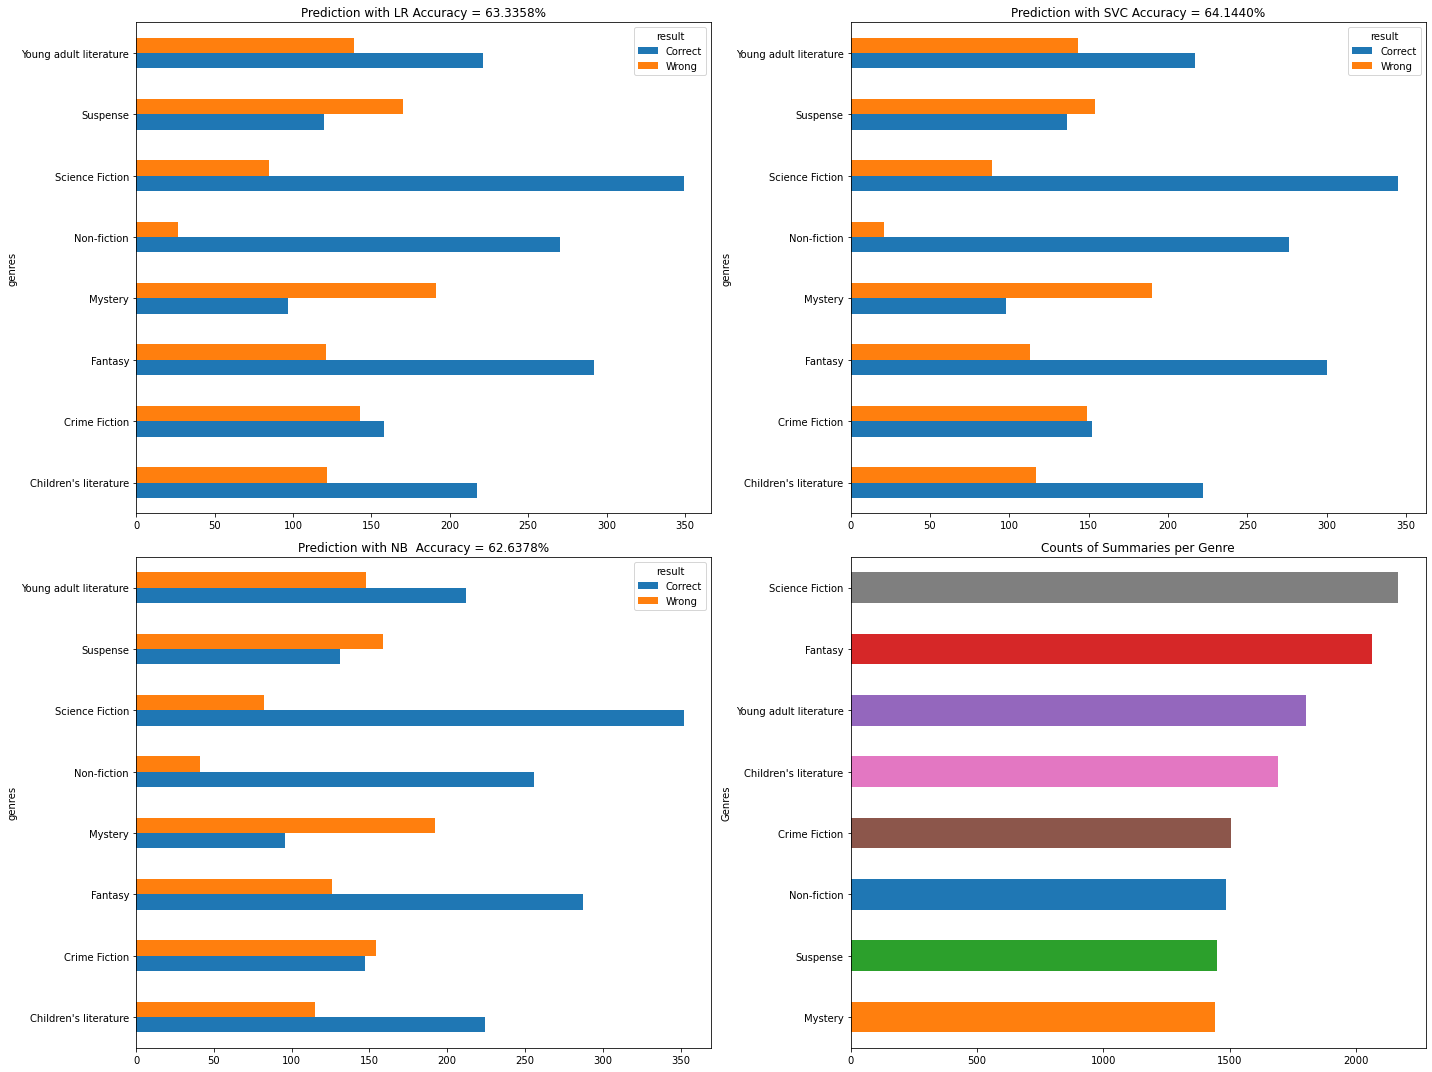

In [37]:
colors=['tab:orange', 'tab:green', 'tab:blue', 'tab:brown', 'tab:pink', 'tab:purple','tab:red', 'tab:gray', 'tab:olive']
#df = book_summary_df.groupby(['Genres'])['String Counts'].sum().reset_index()
#Stats
plt.figure(figsize=(20,15))
plt.subplot(2,2,1).set_title("Prediction with LR Accuracy = {:.4f}%".format(benchmarks['LR_tuned'][2]))
pred_lr_df.pivot_table(index='genres',columns=['result'],aggfunc='size').plot(kind='barh', color=['tab:blue', 'tab:orange'],ax=plt.gca())
plt.subplot(2,2,2).set_title("Prediction with SVC Accuracy = {:.4f}%".format(benchmarks['SVC_tuned'][2]))
pred_svc_df.pivot_table(index='genres',columns=['result'],aggfunc='size').plot(kind='barh', color=['tab:blue', 'tab:orange'],ax=plt.gca())
plt.subplot(2,2,3).set_title("Prediction with NB  Accuracy = {:.4f}%".format(benchmarks['NB_tuned'][2]))
pred_nb_df.pivot_table(index='genres',columns=['result'],aggfunc='size').plot(kind='barh', color=['tab:blue', 'tab:orange'],ax=plt.gca())
plt.subplot(2,2,4).set_title("Counts of Summaries per Genre")
book_summary_df.groupby('Genres').size().sort_values(ascending=True).plot(kind='barh', color=colors,ax=plt.gca())
plt.tight_layout()
plt.show()

# Classification Report
Precision, Recall, F1 Score and Confusion Matrix

In [38]:
from sklearn import metrics
def classification_report(y, pred, target, name):
    print('##########################################\n#\tTest accuracy is {:.4f}%\t#\n##########################################'.format(accuracy_score(y, 
    pred)*100))
    print("------------------------------------------------------------")
    print("Classification Report for model {}".format(name))
    print("------------------------------------------------------------")
    print(metrics.classification_report(y, pred, target_names=target, zero_division=0))
    print("------------------------------------------------------------")
    #print("Confusion Matrix for {}".format(name))
    #print("------------------------------------------------------------")
    #print(metrics.confusion_matrix(y, pred))
    plt.figure(figsize = (20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(metrics.confusion_matrix(y, pred), xticklabels = target, yticklabels = target, annot = True, fmt="d",cmap = 'summer', annot_kws={"size": 12})
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title("Confusion Matrix for {}".format(name))
    plt.show()

##########################################
#	Test accuracy is 62.6378%	#
##########################################
------------------------------------------------------------
Classification Report for model Naive Bayes
------------------------------------------------------------
                        precision    recall  f1-score   support

       Science Fiction       0.60      0.66      0.63       339
         Crime Fiction       0.49      0.49      0.49       301
           Non-fiction       0.69      0.69      0.69       413
 Children's literature       0.65      0.33      0.44       288
               Fantasy       0.81      0.86      0.83       297
               Mystery       0.71      0.81      0.76       434
              Suspense       0.44      0.45      0.44       290
Young adult literature       0.57      0.59      0.58       360

              accuracy                           0.63      2722
             macro avg       0.62      0.61      0.61      2722
          we

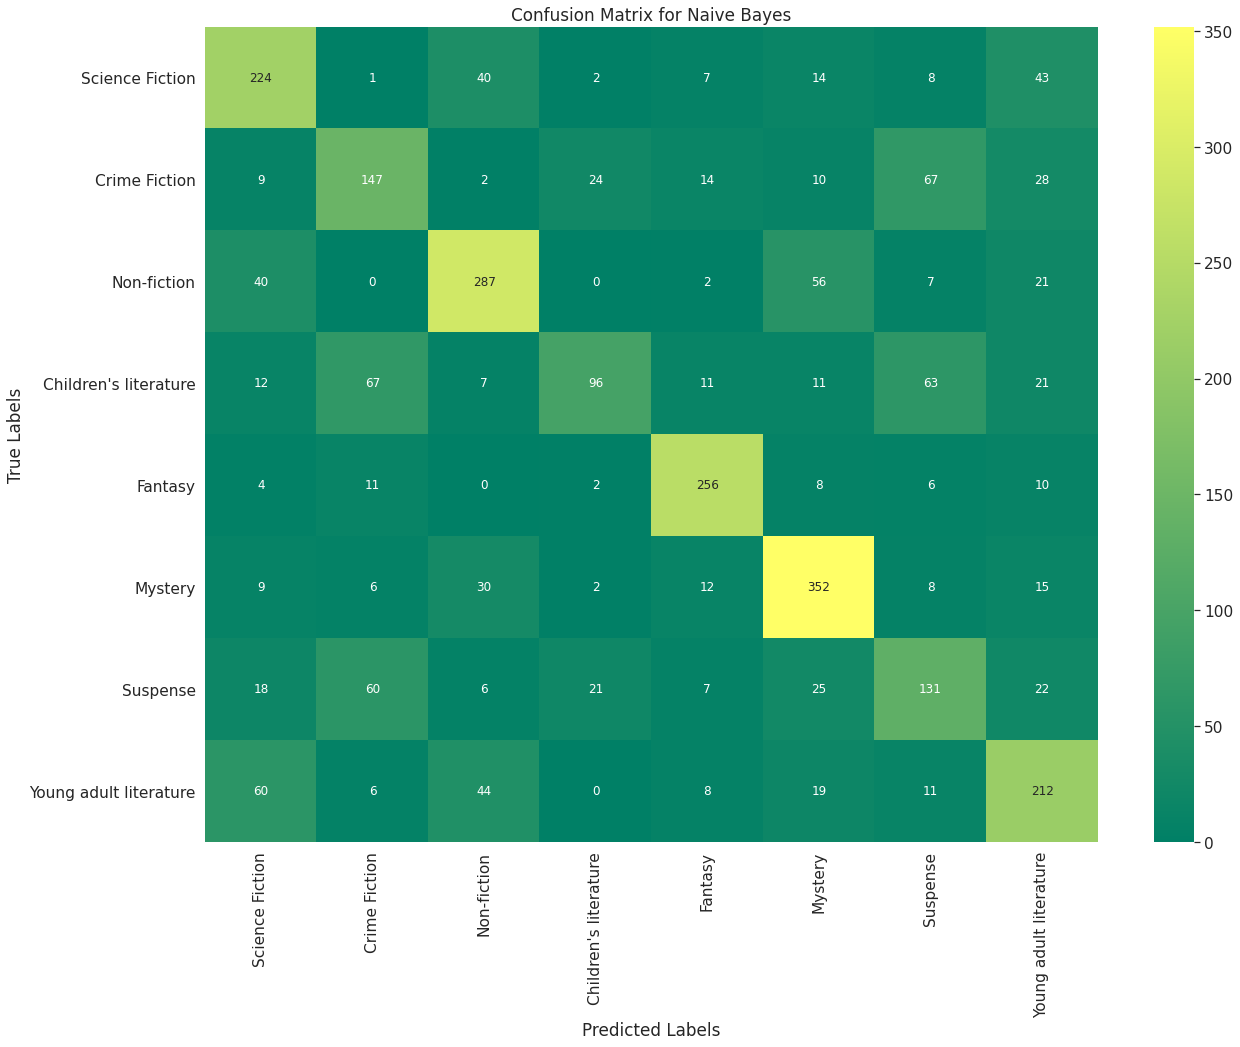

In [39]:
classification_report(test_y, pred_nb, valid_genres, "Naive Bayes")

##########################################
#	Test accuracy is 64.1440%	#
##########################################
------------------------------------------------------------
Classification Report for model Support Vector Classification
------------------------------------------------------------
                        precision    recall  f1-score   support

       Science Fiction       0.64      0.65      0.65       339
         Crime Fiction       0.49      0.50      0.50       301
           Non-fiction       0.67      0.73      0.70       413
 Children's literature       0.64      0.34      0.44       288
               Fantasy       0.79      0.93      0.85       297
               Mystery       0.73      0.79      0.76       434
              Suspense       0.48      0.47      0.47       290
Young adult literature       0.61      0.60      0.61       360

              accuracy                           0.64      2722
             macro avg       0.63      0.63      0.62     

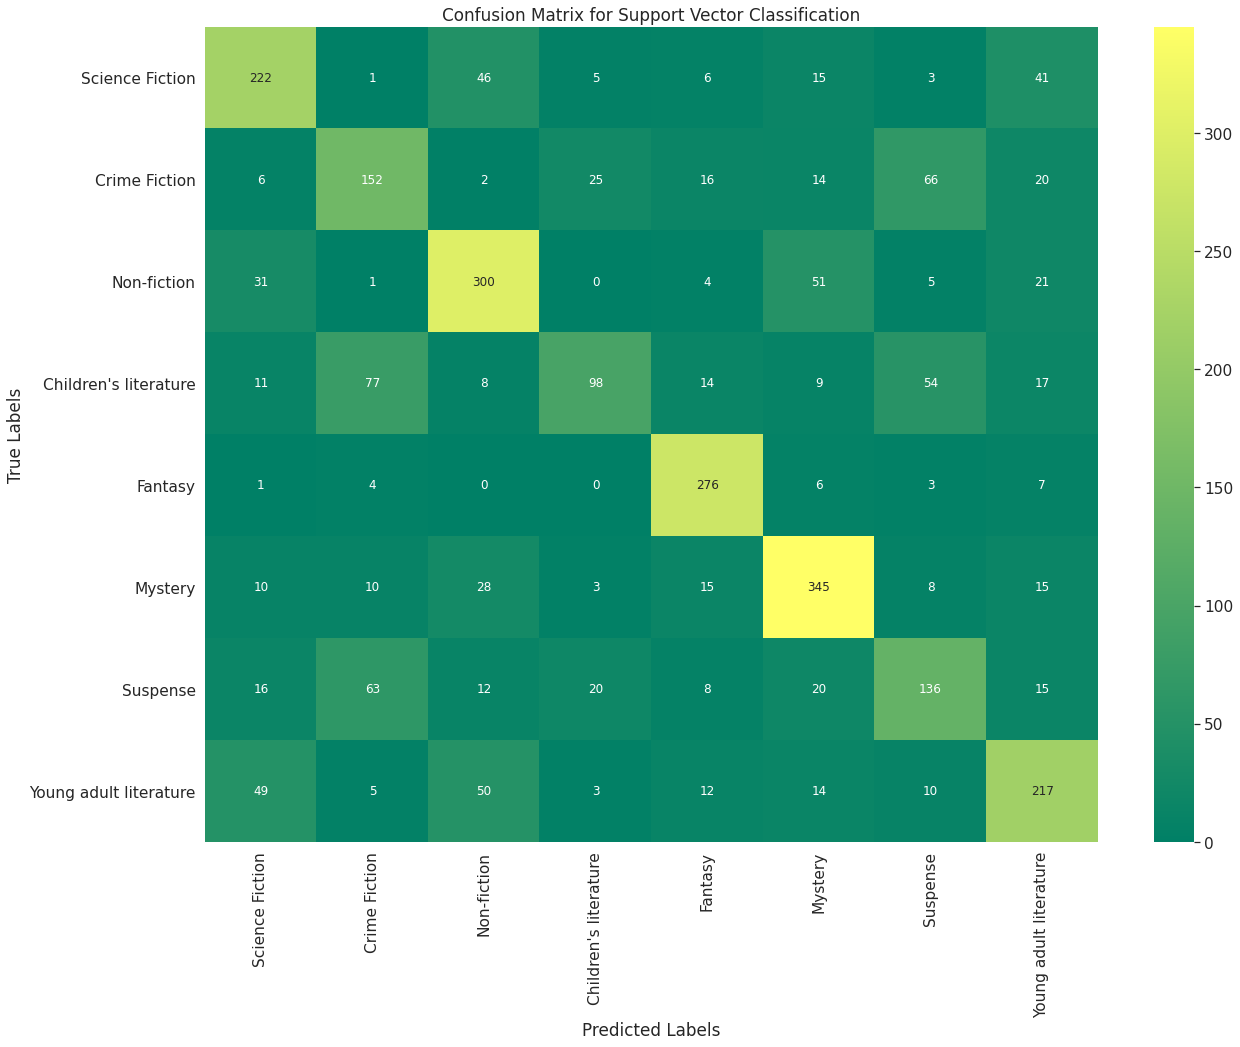

In [40]:
classification_report(test_y, pred_svc, valid_genres, "Support Vector Classification")

##########################################
#	Test accuracy is 63.3358%	#
##########################################
------------------------------------------------------------
Classification Report for model Logistic Regression
------------------------------------------------------------
                        precision    recall  f1-score   support

       Science Fiction       0.61      0.64      0.63       339
         Crime Fiction       0.50      0.52      0.51       301
           Non-fiction       0.65      0.71      0.68       413
 Children's literature       0.58      0.34      0.43       288
               Fantasy       0.80      0.91      0.85       297
               Mystery       0.71      0.80      0.75       434
              Suspense       0.51      0.41      0.46       290
Young adult literature       0.60      0.61      0.61       360

              accuracy                           0.63      2722
             macro avg       0.62      0.62      0.61      2722
    

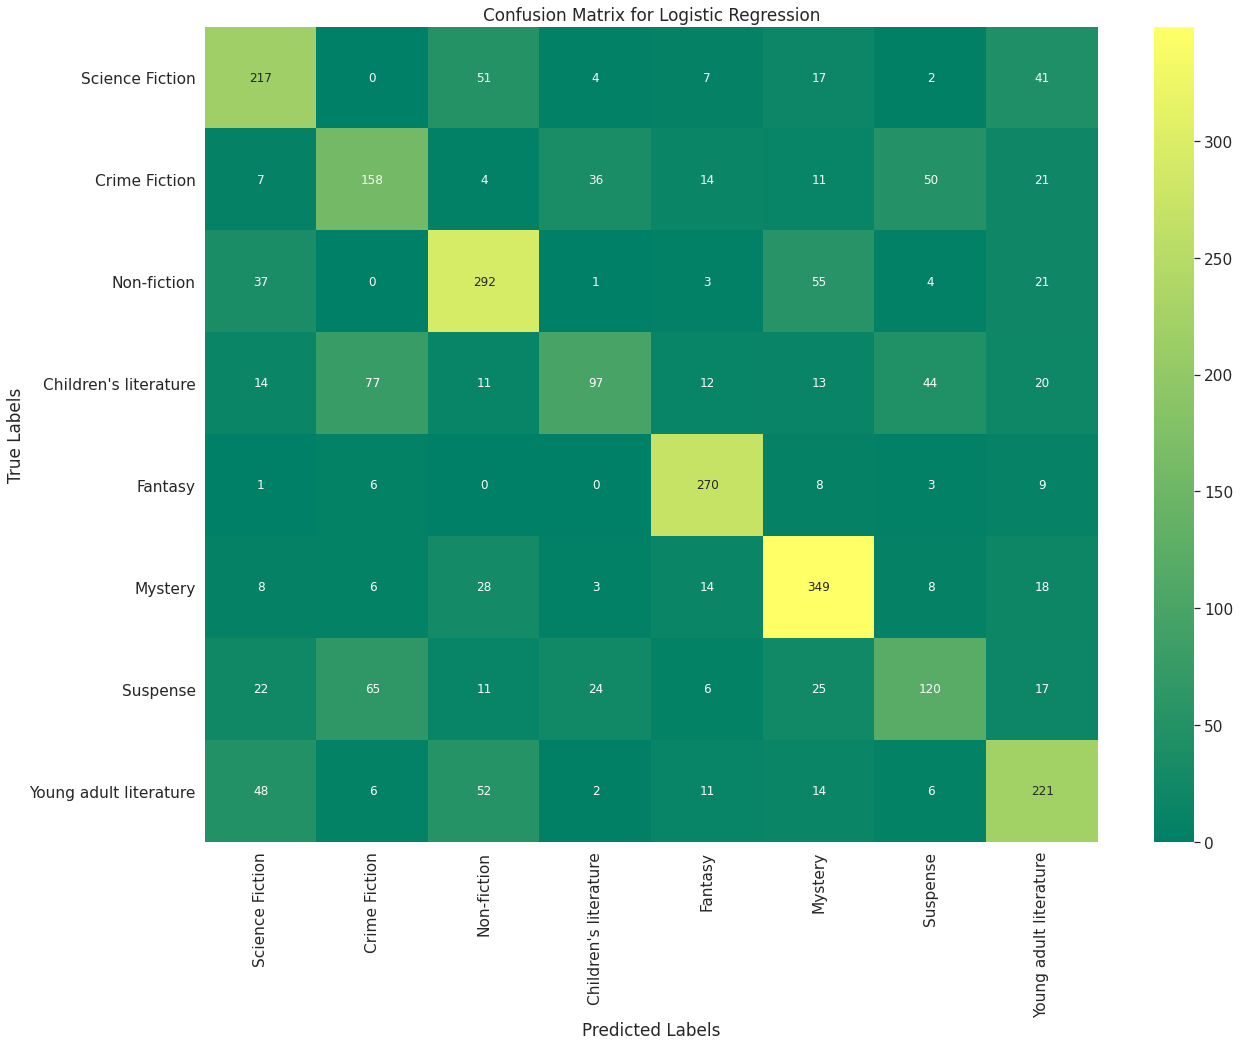

In [41]:
classification_report(test_y, pred_lr, valid_genres, "Logistic Regression")

# Inference function

In [42]:
import pandas as pd
import joblib

In [43]:
import string
import re
def clean(summary):
    table = str.maketrans(dict.fromkeys(string.punctuation))
    text = summary.translate(table)
    text = re.sub(r"[^a-zA-Z0-9\s]"," ", summary.lower())
    return text

In [44]:
def predict_genre(plot):
    s = clean(plot)
    lr_est = joblib.load('./LR_tuned_model.sav')
    svc_est = joblib.load('./SVC_tuned_model.sav')
    nb_est = joblib.load('./NB_tuned_model.sav')
    return (lr_est.best_estimator_.predict([s])[0], svc_est.best_estimator_.predict([s])[0], nb_est.best_estimator_.predict([s])[0])

Test with book summary of Edge of the Grave by Robbie Morrison: https://www.goodreads.com/book/show/56317981-edge-of-the-grave

In [45]:
goodreads_df = pd.read_csv(filepath_or_buffer='../input/load-summaries/summaries_for_testing.csv', header=0,names=['title','author','genre','summary'] )
goodreads_df.dropna(inplace=True)

In [46]:
results= { 'Title': [],
           'Author': [],
           'Prediction LR': [],
           'Prediction SVC': [],
           'Prediction NB': [],
           'Genre': []
                }
plots = goodreads_df.summary
titles = goodreads_df.title
authors = goodreads_df.author
genres = goodreads_df.genre
for i in range(len(goodreads_df)):
    (lr, svc, nb) = predict_genre(plot=plots[i])
    results['Title'].append(titles[i])
    results['Author'].append(authors[i])
    results['Prediction LR'].append(lr)
    results['Prediction SVC'].append(svc)
    results['Prediction NB'].append(nb)
    results['Genre'].append(genres[i])
results_df = pd.DataFrame.from_dict(results, orient='columns')
results_df.head(10)

,Title,Author,Prediction LR,Prediction SVC,Prediction NB,Genre
0,A Court of Silver Flames,Sarah J. Maas,Young adult literature,Young adult literature,Young adult literature,Fantasy
1,Winter's Orbit,Everina Maxwell,Science Fiction,Science Fiction,Science Fiction,Science Fiction
2,The Electric Kingdom,David Arnold,Young adult literature,Science Fiction,Science Fiction,Young adult literature
3,The Lost Apothecary,Sarah Penner,Mystery,Science Fiction,Suspense,Mystery
4,Let Her Lie,Bryan Reardon,Mystery,Mystery,Mystery,Suspense
5,Four Lost Cities: A Secret History of the Urba...,Annalee Newitz,Non-fiction,Non-fiction,Non-fiction,Non-fiction
6,The Year I Flew Away,Marie Arnold,Young adult literature,Young adult literature,Young adult literature,Children's literature
7,Don't Overthink It,Anne Bogel,Non-fiction,Non-fiction,Non-fiction,Non-fiction
8,Ready Player One,Ernest Cline,Young adult literature,Young adult literature,Young adult literature,Speculative fiction
9,The Name of the Rose,Umberto Eco,Suspense,Suspense,Mystery,Crime Fiction
